In [1]:
# for loading and manipulating dataframes
import pandas as pd

# for various plotting functions
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

# to scale our data so that we can perform "sensible" clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# to provide an implementation of the k-means algorithm
from sklearn.cluster import KMeans

import numpy as np
from kmodes.kprototypes import KPrototypes

import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [2]:
pots = pd.read_csv("Pots_clean.csv")
pots.head()

productcode  price       maker                            name  \
0   AM470Y165   47.0  Andy Mason  ovalled bowl cream satin motif   
1   AM470Y164   47.0  Andy Mason  ovalled bowl cream satin motif   
2   AM470Y163   38.0  Andy Mason  dinner plate cream satin plain   
3   AM470Y162   38.0  Andy Mason  dinner plate cream satin plain   
4   AM470Y161   38.0  Andy Mason  dinner plate cream satin plain   

                                         description  height  width  depth  \
0  this stoneware bowl is wheel-thrown with a cre...     8.0   25.5   22.0   
1  this stoneware bowl is wheel-thrown with a cre...     8.0   25.0   22.0   
2  this stoneware plate is wheel-thrown with a cr...     3.0   25.0   15.3   
3  this stoneware plate is wheel-thrown with a cr...     3.0   25.0   15.3   
4  this stoneware plate is wheel-thrown with a cr...     3.0   24.5   15.1   

   materials technique    firing decoration  
0  Stoneware    Thrown  Electric      Glaze  
1  Stoneware    Thrown  Electric      Glaze  
2  Stoneware    Thrown  Electric      Glaze  
3  Stoneware    Thrown  Electric      Glaze  
4  Stoneware    Thrown  Electric      Glaze

In [3]:
# drop variables that are unnecessary to cluster with
pots_final = pots.drop(columns = ["productcode", "name", "description", "maker"])

# columns to be scaled
cols = ["price", "height", "depth", "width"]

scaler = StandardScaler()

pots_final[cols] = pd.DataFrame(scaler.fit_transform(pots[cols]), columns = cols)
pots_final.head(2)

price   height     width     depth  materials technique    firing  \
0 -0.564882 -0.69404  1.085478  2.097354  Stoneware    Thrown  Electric   
1 -0.564882 -0.69404  1.025789  2.097354  Stoneware    Thrown  Electric   

  decoration  
0      Glaze  
1      Glaze

In [4]:
#print out indexes of columns so as to easily refernce categorical columns (for Kprototypes)
for i in pots_final.columns:
    print('{}:'.format(i), pots_final.columns.get_loc(i))

price: 0
height: 1
width: 2
depth: 3
materials: 4
technique: 5
firing: 6
decoration: 7


In [5]:
categorical_columns = [4, 5, 6, 7]

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


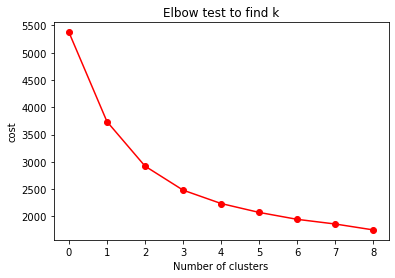

In [6]:
#run an elbow curve of Kprototypes
cost = []
for i_clus in range(1, 10):
        kprototype = KPrototypes(n_clusters = i_clus, init='Huang')
        kprototype.fit_predict(pots_final, categorical=categorical_columns)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(i_clus))
    
plt.plot( cost, 'ro-', label="cost")
plt.title("Elbow test to find k")
plt.xlabel("Number of clusters")
plt.ylabel("cost")
plt.show()

An arbitrary choice, and 3 would be the 'elbow', but 5 categories may be a bit more workable in terms of insights.

In [7]:
kprototype = KPrototypes(n_clusters = 5, init = 'Huang', n_init = 10)
kprototype.fit_predict(pots_final, categorical=categorical_columns)

#Checks of success
print(kprototype.labels_)
print(len(kprototype.labels_))

[4 4 0 ... 0 2 2]
1126


In [8]:
pots_clustered = pots.copy()

#append cluster labels to main dataset 'pots' and create new category
pots_clustered["cluster labels"] = kprototype.labels_
pots_clustered['category'] = pots_clustered['cluster labels'].map({0:'first', 
                                                                   1:'second', 
                                                                   2:'third', 
                                                                   3:'fourth', 
                                                                   4:'fifth'})
pots_clustered.sample(3)

productcode  price                   maker  \
336   JH137Y249  159.0            John Higgins   
284  JTW322Y313  395.0  James and Tilla Waters   
51    JK375Y206   49.0            John Kershaw   

                                 name  \
336                      Shallow Bowl   
284        Large tenmoku serving dish   
51   flattened vase with colour small   

                                           description  height  width  depth  \
336  this earthenware bowl is wheel-thrown with a l...     8.0   26.0   15.7   
284  this beautiful dish is wheel-thrown and decora...     7.5   40.0   21.6   
51   this stoneware vase is hand-built with a sandy...    14.0    7.0    4.5   

       materials   technique    firing       decoration  cluster labels  \
336  Earthenware  Hand built  Electric  Slip decoration               4   
284    Stoneware      Thrown       Gas            Glaze               4   
51     Stoneware  Hand built  Electric            Glaze               2   

    category  
336    fifth  
284    fifth  
51     third

In [9]:
#use a rename 'count' column to count data points per cluster.
pots_clustered.rename(columns = {'cluster labels':'count'}, inplace = True)
pots_clustered.groupby('category').agg(
    {
        'count':'count',
        'materials': lambda x: x.value_counts().index[0], #showcase the category of greatest incidence
        'technique': lambda x: x.value_counts().index[0], #as above etc.
        'firing': lambda x: x.value_counts().index[0],
        'decoration': lambda x: x.value_counts().index[0],
        'price': 'mean',
        'height': 'mean',
        'width': 'mean',
        'depth': 'mean'
    }
).round(1).reset_index().sort_values("count")

category  count    materials   technique    firing decoration   price  \
2   fourth     71    Stoneware  Hand built  Electric      Glaze  2084.0   
0    fifth    118  Earthenware  Hand built  Electric      Glaze   364.5   
3   second    216    Stoneware  Hand built  Electric      Glaze   514.7   
1    first    249    Stoneware      Thrown  Electric      Glaze   166.2   
4    third    472    Porcelain      Thrown  Electric      Glaze   124.8   

   height  width  depth  
2    33.1   28.3   16.5  
0     9.5   30.4   20.8  
3    28.5   17.7   10.8  
1    10.0   18.1   13.1  
4    11.0    9.6    8.2

<br>
Results are interesting! They seem to have clustered appropriately with nice sample sizes per cluster. Let's have a look at a pairplot to see if we can obtain any interpretability.
<br>

<br>

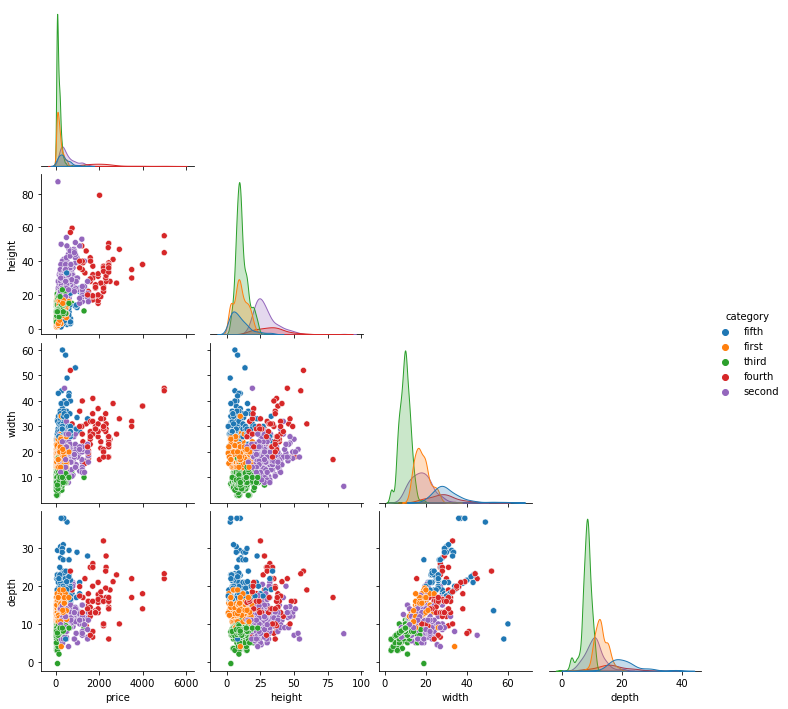

In [10]:
sns.pairplot(pots_clustered.drop(['count'],axis=1), corner = True, hue = 'category')

Not much to the above - Clusters have seperated to a certain degree but it might be interesting to carry out some dimensionality reduction for the sake of visualising our clusters a bit better.

I will encode the categorical variables and plus this into T-SNE and PCA

## T-SNE and PCA

In [11]:
pots_encoded = pd.get_dummies(pots_final)
print(pots_encoded.shape)
print(pots_encoded.columns)

(1126, 19)
Index(['price', 'height', 'width', 'depth', 'materials_Bone China',
       'materials_Earthenware', 'materials_Porcelain', 'materials_Stoneware',
       'technique_Hand built', 'technique_Thrown', 'firing_Electric',
       'firing_Gas', 'firing_Raku', 'firing_Wood', 'decoration_Glaze',
       'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata'],
      dtype='object')


Results are interesting with T-SNE manifolds displaying some concentric circles of data. - Let's try a bit of a gridsearch to represent that more fully. This will allow me to gauge some of the 'success' in clustering.

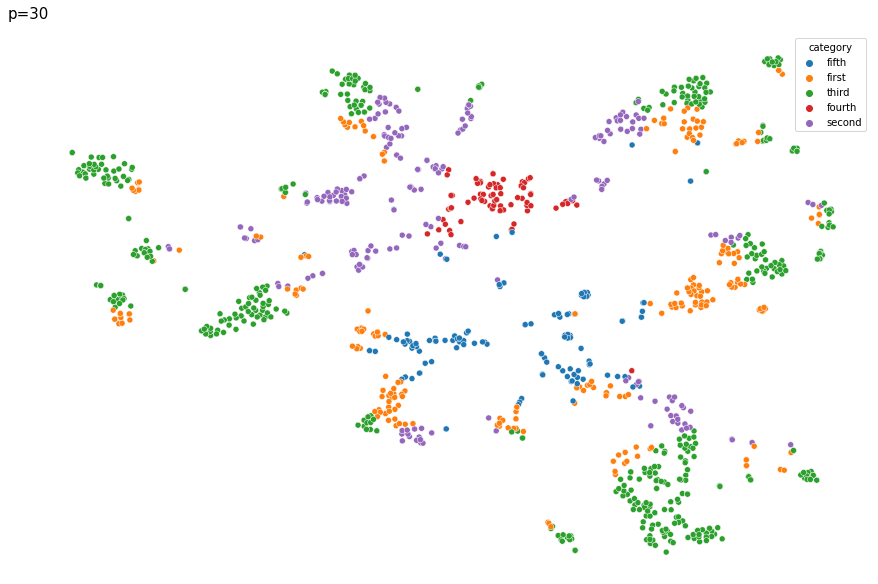

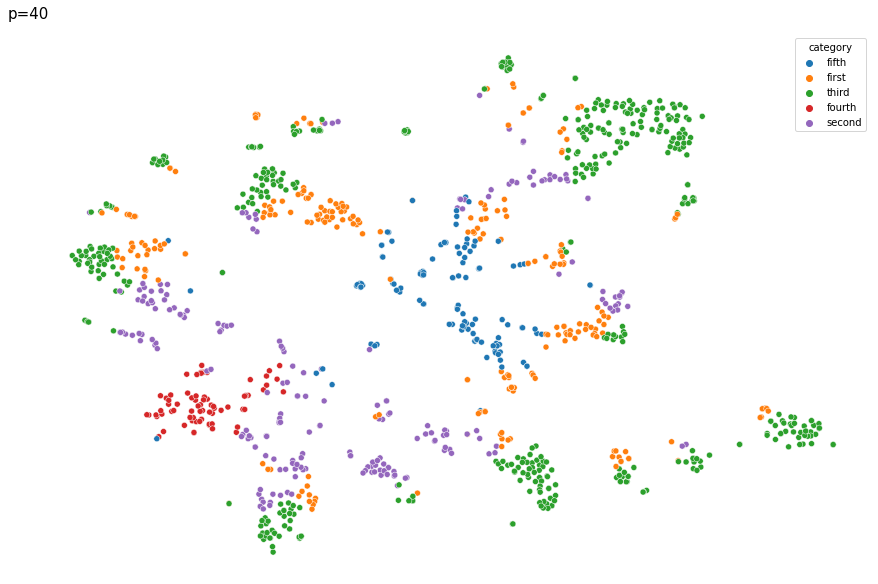

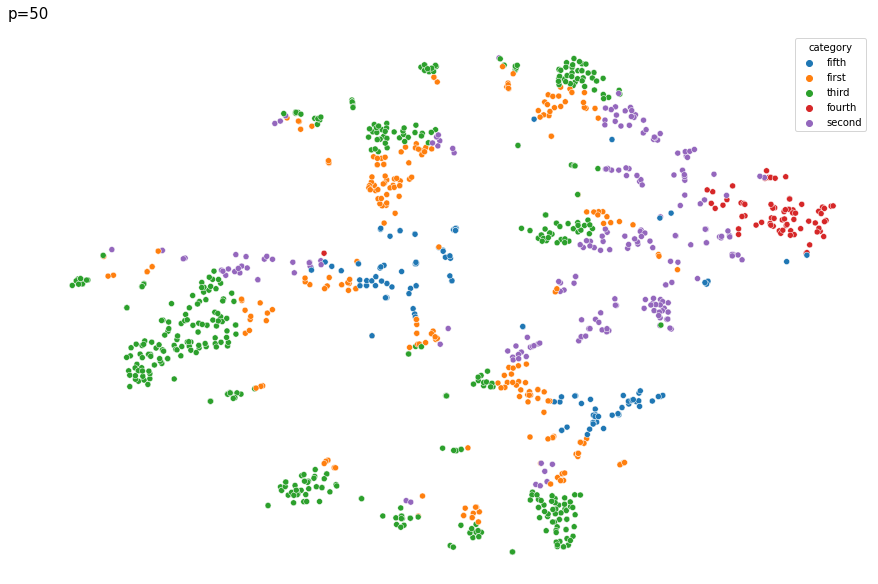

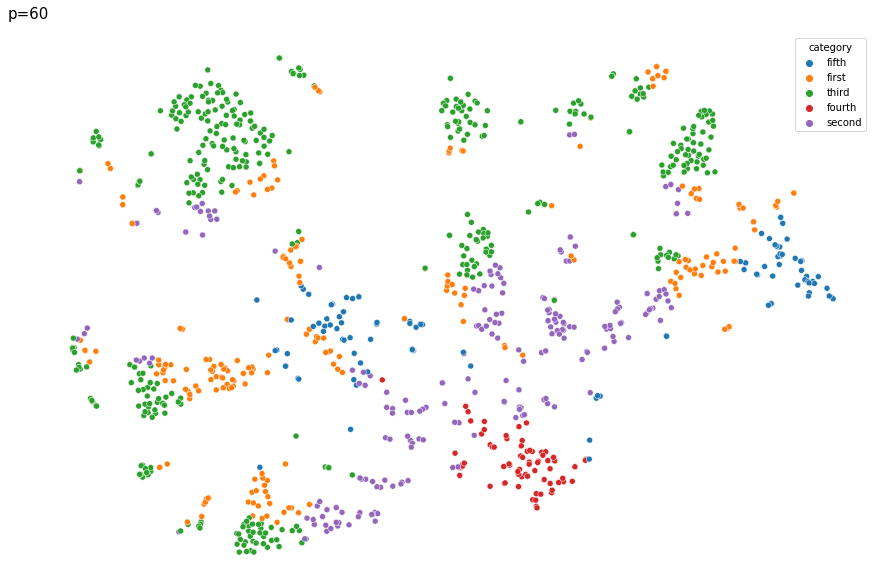

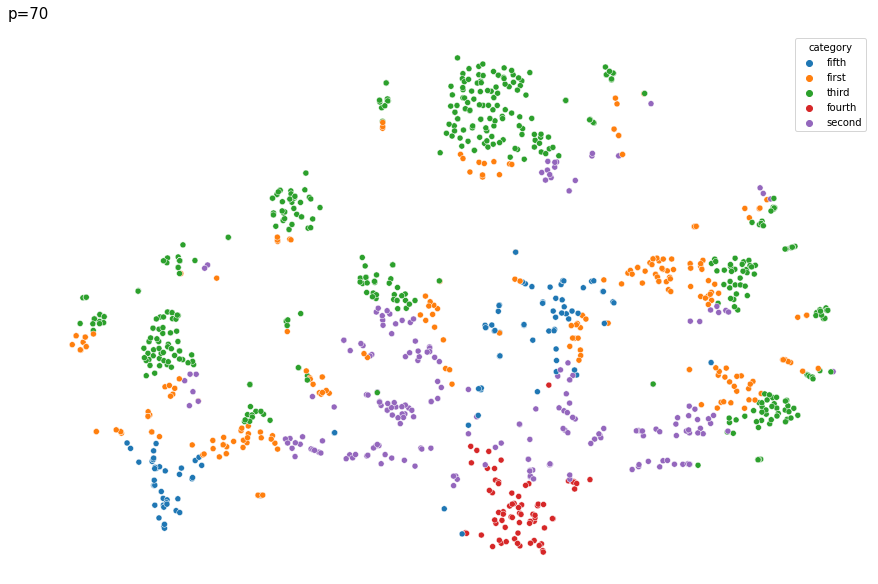

In [13]:
p_s = [30, 40, 50, 60, 70]

for i in p_s:
    tsne = TSNE(perplexity=i, n_iter=10000, init='random', random_state=137)

    embed = tsne.fit_transform(pots_encoded)

    fig, ax = plt.subplots(figsize = (15, 10))
    sns.scatterplot(x=embed[:,0], y=embed[:,1], hue=pots_clustered.category)
    fig.text(0.1, 0.9, 'p={}'.format(str(i)), size=15)
    ax.axis('off');

Some interesting results that raise the question as to whether it would now be worth clustering based on the t-SNE'd data. But let's check PCA first

<AxesSubplot:>

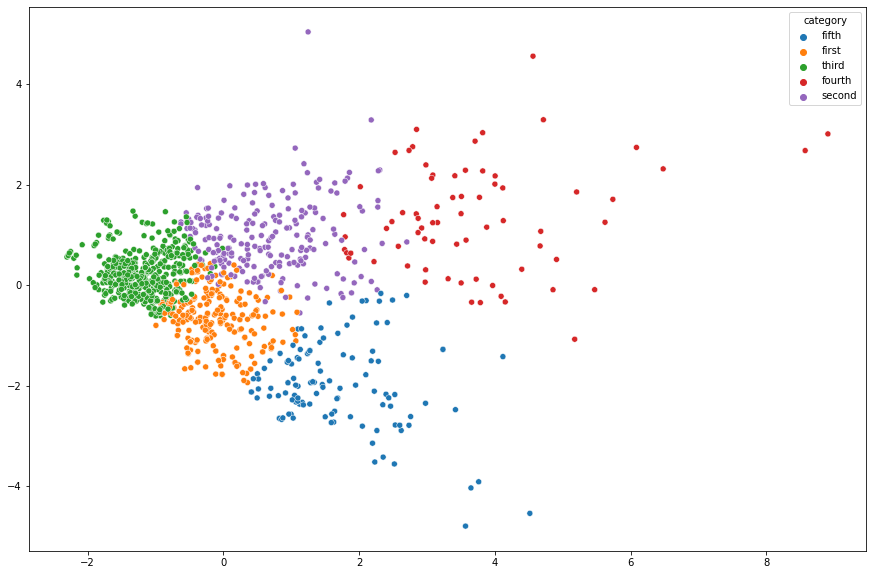

In [14]:
pca = PCA(n_components=2)
embed = pca.fit_transform(pots_encoded)

plt.figure(figsize = (15, 10))
sns.scatterplot(x=embed[:,0], y=embed[:,1], hue=pots_clustered.category)

In [15]:
pca.explained_variance_ratio_

array([0.37393992, 0.20307272])

PCA explains 0.57 - 57% of the variance at n=2 components. PCA shows interesting results of clustering where even with dimensionality reduction the clusters are well preserved. There is some overlap between clusters but that could be as a result of the dimensionality reduction.

## Interpreting clusters (renamed as 'category')

Check to make sure that the primary category in 'materials', 'technique', 'firing' and 'decoration' is justified

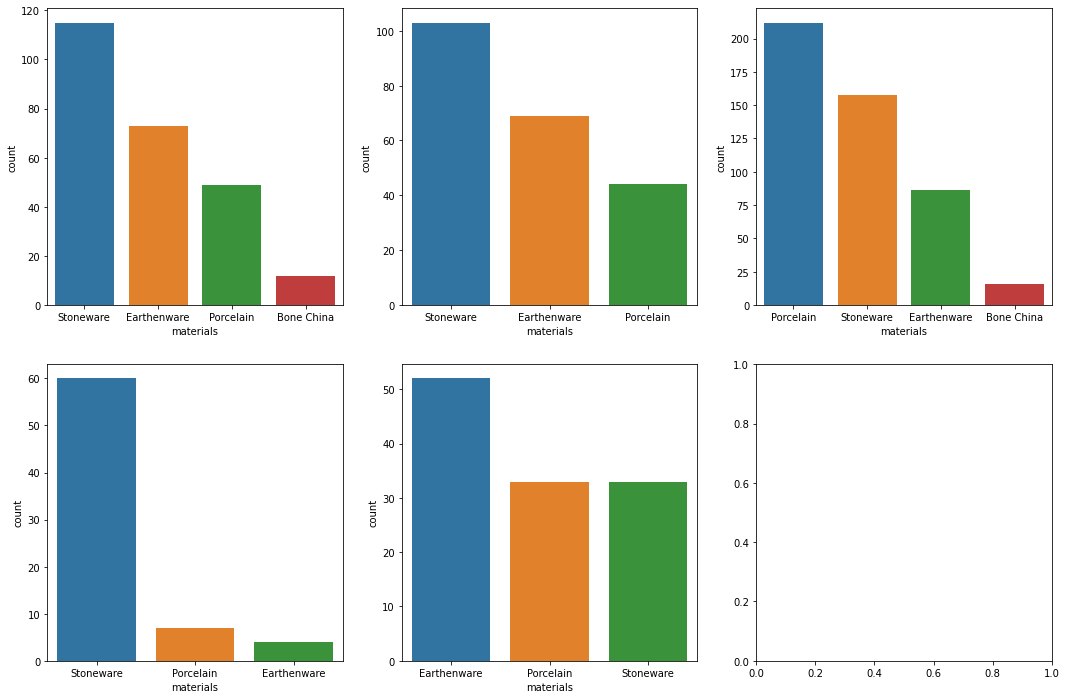

In [16]:
categories = ['first', 'second', 'third', 'fourth', 'fifth']


fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i in range(len(categories)):
    bars = pots.loc[pots_clustered["category"]==categories[i], 'materials']
    bars = bars.reset_index(name='materials').groupby("materials").size()
    bars = bars.reset_index(name='count').sort_values("count", ascending = False)
    sns.barplot(x="materials", y="count", data=bars, ax=axs.ravel()[i])
    ax = axs.ravel()[i]


Seems to be that the clusters are well motivated and the inspection of the table above works well given that the most common material tends to be distinguishably more common than the subsequent materials. this is particularly the case with the fourth cluster.

'first' — small, thrown porcelain

'second' — small, thrown stoneware

'third' — medium, hand built

'fourth' — large, ornate hand built

'fifth' — large, flat hand built earthenware

<br>

Looking back to the original elbow curve, it may be more justified to try k=3 as opposed to k=5. It makes for a cleaner interpretation, especially when looking at the average price of a pot per cluster. 

Additionally, arguabably from the point of view of the shopkeeper, it is easier and more intuitive to categories pots into three - 'cheap', 'middle-priced' and 'expensive'.

It is with this category that we will go ahead and create a classification model. 

In [17]:
kprototype = KPrototypes(n_clusters = 3, init = 'Huang', n_init = 10)
kprototype.fit_predict(pots_final, categorical=categorical_columns)

pots_clustered = pots.copy()

#append cluster labels to main dataset 'pots' and create new category
pots_clustered["cluster labels"] = kprototype.labels_
pots_clustered['category'] = pots_clustered['cluster labels'].map({0:'first', 
                                                                   1:'second', 
                                                                   2:'third'})

#use a rename 'count' column to count data points per cluster.
pots_clustered.rename(columns = {'cluster labels':'count'}, inplace = True)
pots_clustered.groupby('category').agg(
    {
        'count':'count',
        'materials': lambda x: x.value_counts().index[0], #showcase the category of greatest incidence
        'technique': lambda x: x.value_counts().index[0], #as above etc.
        'firing': lambda x: x.value_counts().index[0],
        'decoration': lambda x: x.value_counts().index[0],
        'price': 'mean',
        'height': 'mean',
        'width': 'mean',
        'depth': 'mean'
    }
).round(1).reset_index().sort_values("count")

category  count    materials   technique    firing decoration   price  \
0    first    162    Stoneware  Hand built  Electric      Glaze  1370.4   
1   second    199  Earthenware      Thrown  Electric      Glaze   277.7   
2    third    765    Stoneware      Thrown  Electric      Glaze   163.6   

   height  width  depth  
0    33.2   23.7   14.3  
1     9.2   26.8   18.4  
2    13.2   12.1    9.3

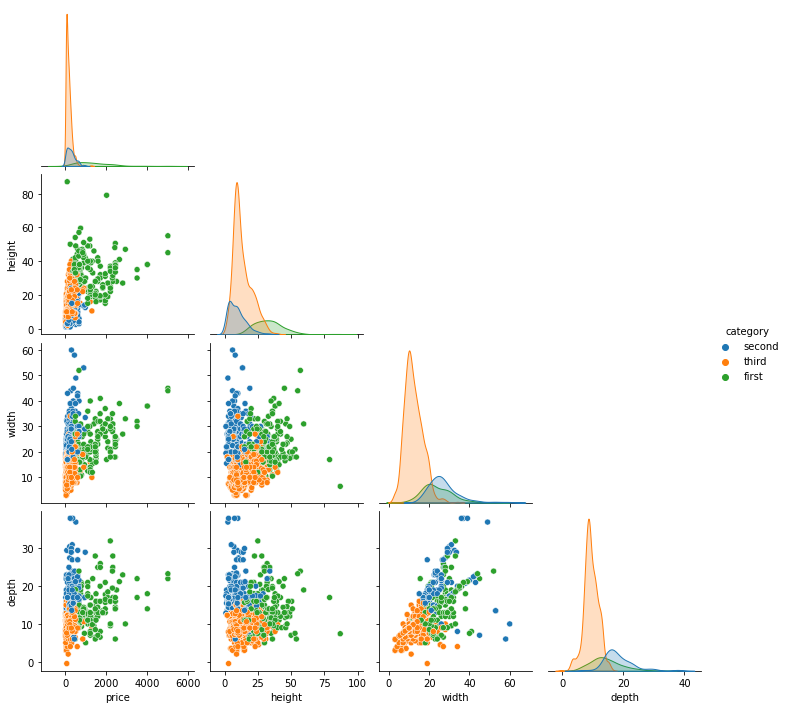

In [18]:
sns.pairplot(pots_clustered.drop(['count'],axis=1), corner = True, hue = 'category')

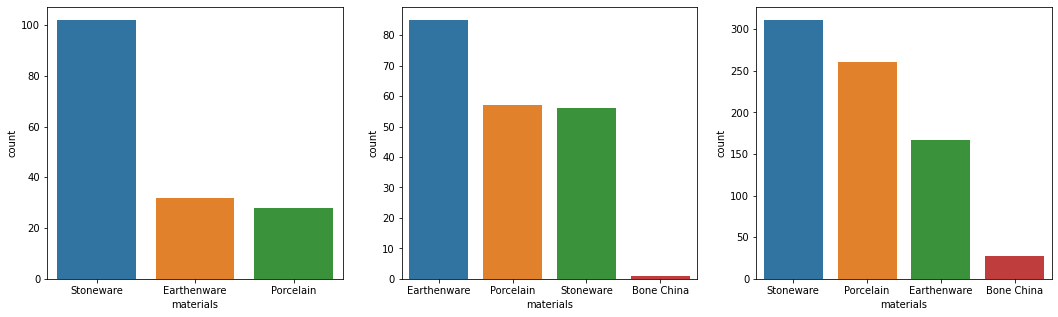

In [19]:
categories = ['first', 'second', 'third']


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i in range(len(categories)):
    bars = pots.loc[pots_clustered["category"]==categories[i], 'materials']
    bars = bars.reset_index(name='materials').groupby("materials").size()
    bars = bars.reset_index(name='count').sort_values("count", ascending = False)
    sns.barplot(x="materials", y="count", data=bars, ax=axs.ravel()[i])
    ax = axs.ravel()[i]

'First': ornate, hand-built pots

'Second': affordable thrown ware

'Third': middle-range thrown ware

In [20]:
pots_clustered.drop(columns='count', inplace = True)
pots_clustered = pots_clustered.set_index('productcode')
pots_clustered.to_csv("Pots_clean_labelled.csv")